<a href="https://colab.research.google.com/github/pablocaron/teaching_fem/blob/main/fe_bar_1D_refinement_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & definition of functions

In the following lines we import the necessary packages to do the numerical calculations and the plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate

Custom functions for this notebook.

In [2]:
def Kbar1D(E,A,x0,x1):
  """Function to calculate the stiffness matrix for a one dimensional bar element with constant properties.
  
  Kbarra2D(E,A,x0,x1):
  E:     Young's modulus
  A:     Element's area
  x0: First  node's x coordinate
  x1: Second node's x coordinate
  """
  L=np.abs(x1-x0)     # Length of the element
  k=E*A/L             # Stiffness of the bar

  return np.array([[k,-k],[-k,k]])

def Fbar1D_f(f,x0,x1):
  """Function to calculate the force vector due to a load distribution f(x)
  
  Fbar1D_f(f,x0,x1):
  f:  function to describe the load distribution
  x0: First  node's x coordinate
  x1: Second node's x coordinate 
  """
  F1=integrate.quad(lambda x: f(x)*(x-x1)/(x0-x1),x0,x1)[0] # Force distribution weighted with the first Lagrange function
  F2=integrate.quad(lambda x: f(x)*(x-x0)/(x1-x0),x0,x1)[0] # Force distribution weighted with the second Lagrange function
  return np.array([[F1],[F2]])



def assembleK(klocal,kglobal,conec):
  """
  Function to assemble the local matrix klocal into the kglobal matrix following the conectivity conec

  This function assumes that the matrices have the correct dimensions.
  klocal:  Local matrix of the assembled element
  kglobal: Global matrix
  conec:   conectivity matrix for the assembled element
  """
  klocalsize=np.shape(klocal)
  for i in range(klocalsize[1]):
    for j in range(klocalsize[1]):
      kglobal[conec[i],conec[j]]+=klocal[i,j]
  return kglobal

def assembleF(flocal,fglobal,conec):
  """
  Function to assemble the local vector flocal into the global vector fglobal following the conectivity conec

  This function assumes that the matrices have the correct dimensions.
  flocal:  Local vector of the assembled element
  fglobal: Global vector
  conec:   conectivity matrix for the assembled element
  """
  flocalsize=np.shape(flocal)
  for i in range(flocalsize[0]):
    fglobal[conec[i]]+=flocal[i,0]
  return fglobal

# Problem to solve

## PDE for a bar problem
The partial differential equation for a one dimensional bar is
$$
\frac{\partial}{\partial x} \left( E A(x) \left( \frac{\partial u}{\partial x}-\alpha \Delta T(x,t)\right)\right)-\rho A(x) \frac{\partial^2 u}{\partial t^2}=-p(x,t)
$$
For a steady state problem with constant properties and isotermic conditions, the previous equation reduces to
$$
E A \frac{\partial^2 u}{\partial x^2}=-p(x)
$$
which must be supplemented with boundary conditions.

To analyze the converge of the finite element solution we propose an ad-hoc solution and find the corresponding force $p(x)$. Then, use this force as an input for the finite element model.

The proposed solution is
$$u(x)=sin\left(\frac{\pi x}{2L}\right)$$
which fulfills the boundary conditions
$$u(x)=0\\
  u'(L)=0
$$
Then, 
$$-EA \left(\frac{\pi}{2L}\right)^2sin\left(\frac{\pi x}{2L}\right)=-p(x)$$
So, the distributed force to be used as the input is
$$p(x)=EA \left(\frac{\pi}{2L}\right)^2sin\left(\frac{\pi x}{2L}\right)$$


The properties for the problem are

In [3]:
Eyoung=1  # Young modulus [N/mm^2]
A=1       # Bar's area
L=1       # Lenght of the bar                                     

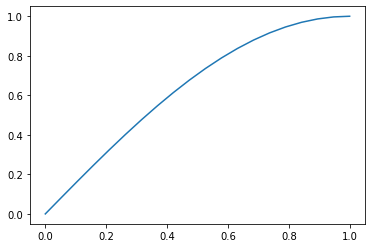

In [4]:
def exact(x):
  """ Function to describe the proposed solution of the PDE"""
  return np.sin(x*np.pi/(2*L))

x=np.linspace(0,1,20)  # Linear space to plot the function exact(x)
y=exact(x)             # exact function evaluated at the x points
plt.plot(x,y)          # Plot the function

The ad-hoc force distribution is

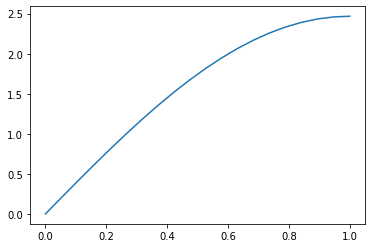

In [5]:
def qx(x):
  """Function to describe the force distribution"""
  return Eyoung*A*(np.pi/(2*L))**2*np.sin(x*np.pi/(2*L))

x=np.linspace(0,L,20) # Linear space to plot the force distribution
y=qx(x)               # Force distribution evaluated at the x points
plt.plot(x,y)         # Plot the function

## Finite element solution (one element)

In [6]:
coord1e=np.linspace(0,L,2) # Coordinates of the nodes
coord1e                    # Show the values of coord1e

array([0., 1.])

The conectivity of each elements is stored in the following array

In [7]:
conectivity=np.array([[0,1]]) # Conectivity of the elements

First we create the stiffness matrix and force vector for each element

In [8]:
k0=Kbar1D(Eyoung,A,coord1e[0],coord1e[1]) # Local stiffness matrix for the first element
f0=Fbar1D_f(qx,coord1e[0],coord1e[1])     # Local force vector for the first element

Second we assemble these matrices into the global stiffness matrix

In [9]:
Ndof=np.max(conectivity)+1            # This is the number of degrees of freedom in the system.
KG=np.zeros([Ndof,Ndof])              # Initialize the global stiffness matrix with zeros
FG=np.zeros([Ndof,1])                 # Initialize the global force vector with zeros

KG=assembleK(k0,KG,conectivity[0])    # Assemble the first element in the global matrix
FG=assembleF(f0,FG,conectivity[0])    # Assemble the first element in the global vector

### Apply the restriction to node 0

In [10]:
dof_I=[0]                             # Degrees of freedom chosen as restricted (known)
dof_II=[1]                            # Degrees of freedom chosen as free (unknown)

In [11]:
K_I_I  = KG[np.ix_(dof_I,dof_I)]      # Submatrix extraction for the restricted dofs
K_I_II = KG[np.ix_(dof_I,dof_II)]     # Submatrix extraction for the mixed dofs
K_II_II= KG[np.ix_(dof_II,dof_II)]    # Submatrix extraction for the free dofs
FG_I   = FG[np.ix_(dof_I,[0])]        # Subvector extraction for the restricted dofs
FG_II  = FG[np.ix_(dof_II,[0])]       # Subvector extraction for the free dofs

The solution for the II set of degrees of freedom is

In [12]:
uf=np.matmul(np.linalg.inv(K_II_II),FG_II) # Solve the system of equations
print(uf)

[[1.]]


In [13]:
sol1e=np.zeros([Ndof,1])              # Create a vector filled with zeros to store the solution
sol1e[np.ix_(dof_II,[0])]=uf          # Add the uf solution to the global vector

## Finite element solution (two elements)

In [14]:
coord2e=np.linspace(0,L,3) # Coordinates of the nodes
coord2e                    # Show the values of coord2e

array([0. , 0.5, 1. ])

The conectivity of each elements is stored in the following array

In [15]:
conectivity=np.array([[0,1],[1,2]]) # Conectivity of the elements

First we create the stiffness matrix and force vector for each element

In [16]:
k0=Kbar1D(Eyoung,A,coord2e[0],coord2e[1]) # Local stiffness matrix for the first element
f0=Fbar1D_f(qx,coord2e[0],coord2e[1])
k1=Kbar1D(Eyoung,A,coord2e[1],coord2e[2]) # Local stiffness matrix for the second element
f1=Fbar1D_f(qx,coord2e[1],coord2e[2])

Second we assemble these matrices into the global stiffness matrix

In [17]:
Ndof=np.max(conectivity)+1            # This is the number of degrees of freedom in the system.
KG=np.zeros([Ndof,Ndof])              # Initialize the global stiffness matrix with zeros
FG=np.zeros([Ndof,1])                 # Initialize the global force vector with zeros

KG=assembleK(k0,KG,conectivity[0])    # Assemble the first element in the global matrix
FG=assembleF(f0,FG,conectivity[0])    # Assemble the first element in the global vector
KG=assembleK(k1,KG,conectivity[1])    # Assemble the second element in the global matrix
FG=assembleF(f1,FG,conectivity[1])    # Assemble the second element in the global vector

### Apply the restriction to node 0

In [18]:
dof_I=[0]                             # Degrees of freedom chosen as restricted (known)
dof_II=[1,2]                          # Degrees of freedom chosen as free (unknown)

In [19]:
K_I_I  = KG[np.ix_(dof_I,dof_I)]      # Submatrix extraction for the restricted dofs
K_I_II = KG[np.ix_(dof_I,dof_II)]     # Submatrix extraction for the mixed dofs
K_II_II= KG[np.ix_(dof_II,dof_II)]    # Submatrix extraction for the free dofs
FG_I   = FG[np.ix_(dof_I,[0])]        # Subvector extraction for the restricted dofs
FG_II  = FG[np.ix_(dof_II,[0])]       # Subvector extraction for the free dofs

The solution for the II set of degrees of freedom is

In [20]:
uf=np.matmul(np.linalg.inv(K_II_II),FG_II) # Solve the system of equations
print(uf)

[[0.70710678]
 [1.        ]]


In [21]:
sol2e=np.zeros([Ndof,1])              # Create a vector filled with zeros to store the solution
sol2e[np.ix_(dof_II,[0])]=uf          # Add the uf solution to the global vector

## Finite element solution (four elements)

In [22]:
coord4e=np.linspace(0,L,5) # Coordinates of the nodes
coord4e                    # Show the values of coord4e

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

The conectivity of each elements is stored in the following array

In [23]:
conectivity=np.array([[0,1],[1,2],[2,3],[3,4]]) # Conectivity of the elements

First we create the stiffness matrix and force vector for each element

In [24]:
k0=Kbar1D(Eyoung,A,coord4e[0],coord4e[1]) # Local stiffness matrix for the first element
f0=Fbar1D_f(qx,coord4e[0],coord4e[1])     # Local force vector for the first element
k1=Kbar1D(Eyoung,A,coord4e[1],coord4e[2]) # Local stiffness matrix for the second element
f1=Fbar1D_f(qx,coord4e[1],coord4e[2])     # Local force vector for the second element
k2=Kbar1D(Eyoung,A,coord4e[2],coord4e[3]) # Local stiffness matrix for the third element
f2=Fbar1D_f(qx,coord4e[2],coord4e[3])     # Local force vector for the third element
k3=Kbar1D(Eyoung,A,coord4e[3],coord4e[4]) # Local stiffness matrix for the fourth element
f3=Fbar1D_f(qx,coord4e[3],coord4e[4])     # Local force vector for the fourth element

Second we assemble these matrices into the global stiffness matrix

In [25]:
Ndof=np.max(conectivity)+1            # This is the number of degrees of freedom in the system.
KG=np.zeros([Ndof,Ndof])              # Initialize the global stiffness matrix with zeros
FG=np.zeros([Ndof,1])                 # Initialize the global force vector with zeros

KG=assembleK(k0,KG,conectivity[0])    # Assemble the first element in the global matrix
FG=assembleF(f0,FG,conectivity[0])    # Assemble the first element in the global vector
KG=assembleK(k1,KG,conectivity[1])    # Assemble the second element in the global matrix
FG=assembleF(f1,FG,conectivity[1])    # Assemble the second element in the global vector
KG=assembleK(k2,KG,conectivity[2])    # Assemble the third element in the global matrix
FG=assembleF(f2,FG,conectivity[2])    # Assemble the third element in the global vector
KG=assembleK(k3,KG,conectivity[3])    # Assemble the fourth element in the global matrix
FG=assembleF(f3,FG,conectivity[3])    # Assemble the fourth element in the global vector

### Apply the restriction to node 0

In [26]:
dof_I=[0]                             # Degrees of freedom chosen as restricted (known)
dof_II=[1,2,3,4]                      # Degrees of freedom chosen as free (unknown)

In [27]:
K_I_I  = KG[np.ix_(dof_I,dof_I)]      # Submatrix extraction for the restricted dofs
K_I_II = KG[np.ix_(dof_I,dof_II)]     # Submatrix extraction for the mixed dofs
K_II_II= KG[np.ix_(dof_II,dof_II)]    # Submatrix extraction for the free dofs
FG_I   = FG[np.ix_(dof_I,[0])]        # Subvector extraction for the restricted dofs
FG_II  = FG[np.ix_(dof_II,[0])]       # Subvector extraction for the free dofs

The solution for the II set of degrees of freedom is

In [28]:
uf=np.matmul(np.linalg.inv(K_II_II),FG_II) # Solve the system of equations
print(uf)

[[0.38268343]
 [0.70710678]
 [0.92387953]
 [1.        ]]


In [29]:
sol4e=np.zeros([Ndof,1])              # Create a vector filled with zeros to store the solution
sol4e[np.ix_(dof_II,[0])]=uf

## Finite element solution (eight elements)

In [30]:
coord8e=np.linspace(0,L,9) # Coordinates of the nodes
coord8e                    # Show the values of coord8e

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

The conectivity of each elements is stored in the following array

In [31]:
conectivity=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8]]) # Conectivity of the elements

First we create the stiffness matrix and force vector for each element

In [32]:
k0=Kbar1D(Eyoung,A,coord8e[0],coord8e[1]) # Local stiffness matrix for the first element
f0=Fbar1D_f(qx,coord8e[0],coord8e[1])     # Local force vector for the first element
k1=Kbar1D(Eyoung,A,coord8e[1],coord8e[2]) # Local stiffness matrix for the second element
f1=Fbar1D_f(qx,coord8e[1],coord8e[2])     # Local force vector for the second element
k2=Kbar1D(Eyoung,A,coord8e[2],coord8e[3]) # Local stiffness matrix for the third element
f2=Fbar1D_f(qx,coord8e[2],coord8e[3])     # Local force vector for the third element
k3=Kbar1D(Eyoung,A,coord8e[3],coord8e[4]) # Local stiffness matrix for the fourth element
f3=Fbar1D_f(qx,coord8e[3],coord8e[4])     # Local force vector for the fourth element
k4=Kbar1D(Eyoung,A,coord8e[4],coord8e[5]) # Local stiffness matrix for the fifth element
f4=Fbar1D_f(qx,coord8e[4],coord8e[5])     # Local force vector for the fifth element
k5=Kbar1D(Eyoung,A,coord8e[5],coord8e[6]) # Local stiffness matrix for the sixth element
f5=Fbar1D_f(qx,coord8e[5],coord8e[6])     # Local force vector for the sixth element
k6=Kbar1D(Eyoung,A,coord8e[6],coord8e[7]) # Local stiffness matrix for the seventh element
f6=Fbar1D_f(qx,coord8e[6],coord8e[7])     # Local force vector for the seventh element
k7=Kbar1D(Eyoung,A,coord8e[7],coord8e[8]) # Local stiffness matrix for the eighth element
f7=Fbar1D_f(qx,coord8e[7],coord8e[8])     # Local force vector for the eighth element

Second we assemble these matrices into the global stiffness matrix

In [33]:
Ndof=np.max(conectivity)+1            # This is the number of degrees of freedom in the system.
KG=np.zeros([Ndof,Ndof])              # Initialize the global stiffness matrix with zeros
FG=np.zeros([Ndof,1])                 # Initialize the global force vector with zeros

KG=assembleK(k0,KG,conectivity[0])    # Assemble the first element in the global matrix
FG=assembleF(f0,FG,conectivity[0])    # Assemble the first element in the global vector
KG=assembleK(k1,KG,conectivity[1])    # Assemble the second element in the global matrix
FG=assembleF(f1,FG,conectivity[1])    # Assemble the second element in the global vector
KG=assembleK(k2,KG,conectivity[2])    # Assemble the third element in the global matrix
FG=assembleF(f2,FG,conectivity[2])    # Assemble the third element in the global vector
KG=assembleK(k3,KG,conectivity[3])    # Assemble the fourth element in the global matrix
FG=assembleF(f3,FG,conectivity[3])    # Assemble the fourth element in the global vector
KG=assembleK(k4,KG,conectivity[4])    # Assemble the fifth element in the global matrix
FG=assembleF(f4,FG,conectivity[4])    # Assemble the fifth element in the global vector
KG=assembleK(k5,KG,conectivity[5])    # Assemble the sixth element in the global matrix
FG=assembleF(f5,FG,conectivity[5])    # Assemble the sixth element in the global vector
KG=assembleK(k6,KG,conectivity[6])    # Assemble the seventh element in the global matrix
FG=assembleF(f6,FG,conectivity[6])    # Assemble the seventh element in the global vector
KG=assembleK(k7,KG,conectivity[7])    # Assemble the eighth element in the global matrix
FG=assembleF(f7,FG,conectivity[7])    # Assemble the eighth element in the global vector

### Apply the restriction to node 0

In [34]:
dof_I=[0]                             # Degrees of freedom chosen as restricted (known)
dof_II=[1,2,3,4,5,6,7,8]              # Degrees of freedom chosen as free (unknown)

In [35]:
K_I_I  = KG[np.ix_(dof_I,dof_I)]      # Submatrix extraction for the restricted dofs
K_I_II = KG[np.ix_(dof_I,dof_II)]     # Submatrix extraction for the mixed dofs
K_II_II= KG[np.ix_(dof_II,dof_II)]    # Submatrix extraction for the free dofs
FG_I   = FG[np.ix_(dof_I,[0])]        # Subvector extraction for the restricted dofs
FG_II  = FG[np.ix_(dof_II,[0])]       # Subvector extraction for the free dofs

The solution for the II set of degrees of freedom is

In [36]:
uf=np.matmul(np.linalg.inv(K_II_II),FG_II) # Solve the system of equations
print(uf)

[[0.19509032]
 [0.38268343]
 [0.55557023]
 [0.70710678]
 [0.83146961]
 [0.92387953]
 [0.98078528]
 [1.        ]]


In [37]:
sol8e=np.zeros([Ndof,1])              # Create a vector filled with zeros to store the solution
sol8e[np.ix_(dof_II,[0])]=uf          # Add the uf solution to the global vector

## Solution comparison

<function matplotlib.pyplot.show>

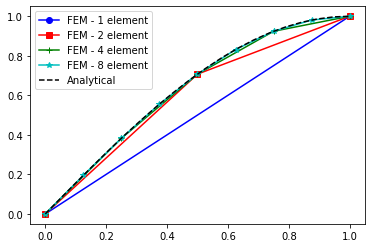

In [38]:
plt.plot(coord1e,sol1e,"bo-")
plt.plot(coord2e,sol2e,"rs-")
plt.plot(coord4e,sol4e,"g+-")
plt.plot(coord8e,sol8e,"c*-")
plt.plot(x,np.sin(x*np.pi/2),"k--")
plt.legend(["FEM - 1 element","FEM - 2 element","FEM - 4 element","FEM - 8 element","Analytical"])
plt.show

## Convergence analysis

<function matplotlib.pyplot.show>

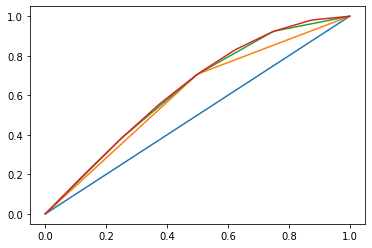

In [45]:
xErr=np.linspace(0,L,100)
exactaErr=exact(xErr)
uApp1e=interpolate.interp1d(coord1e,sol1e[:,0])
uApp2e=interpolate.interp1d(coord2e,sol2e[:,0])
uApp4e=interpolate.interp1d(coord4e,sol4e[:,0])
uApp8e=interpolate.interp1d(coord8e,sol8e[:,0])
plt.plot(xErr,uApp1e(xErr),xErr,uApp2e(xErr),xErr,uApp4e(xErr),xErr,uApp8e(xErr))
plt.show

In [40]:
err1e_L2=np.sqrt(np.trapz((uApp1e(xErr)-exactaErr)**2,x=xErr))
err2e_L2=np.sqrt(np.trapz((uApp2e(xErr)-exactaErr)**2,x=xErr))
err4e_L2=np.sqrt(np.trapz((uApp4e(xErr)-exactaErr)**2,x=xErr))
err8e_L2=np.sqrt(np.trapz((uApp8e(xErr)-exactaErr)**2,x=xErr))

In [41]:
hList=[L,L/2,L/4,L/8]
errList=[err1e_L2,err2e_L2,err4e_L2,err8e_L2]
errList

[0.15087698293834545,
 0.039284347565335005,
 0.009920919860140905,
 0.002486501326500692]

<function matplotlib.pyplot.show>

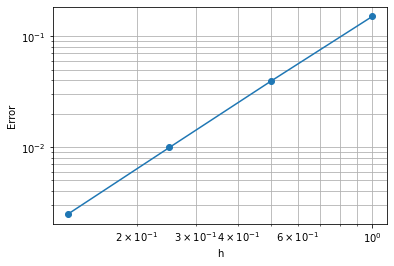

In [46]:
plt.loglog(hList,errList,"o-")
plt.xlabel("h")
plt.ylabel("Error")
plt.grid(which="both")
plt.show

The error is proportional to the power $n$ of the discretization
$$e\propto C h^n$$
then
$$log(e)\propto n\ log(h)+log(C)$$
where $n$ is the *order of convergence* of the method. This value can be found using experimental (numerical) data to obtain the Experimental Order fo Convergence (EOC).

In [43]:
logerr=np.log(errList)
logh  =np.log(hList)

In [44]:
np.polyfit(logh,logerr,1)

array([ 1.9754744, -1.8806102])